In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

from copy import deepcopy
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import spatial
from sklearn.metrics import r2_score
import sys

sys.path.append('..')
from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from utils import load_window_from_chunks
from parameter_choosing import *
from performance_metrics import *

# Neural Data AIC

### Load Some Data

In [4]:
session = 'MrJones-Anesthesia-20160109-01'
# session = 'Mary-Anesthesia-20160912-02'

In [5]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [6]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [7]:
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
        pre=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        during=(eyes_close, session_info['drugEnd'][1]),
        post=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())
areas = np.unique(electrode_info['area'])
areas = np.hstack([areas, 'all'])

In [128]:
# sample times
# sample_nums = {'pre': 4, 'induction': 1, 'during': 4, 'post':2}
sample_nums = {'pre': 1, 'induction': 0, 'during': 1, 'post':0}
sample_ts = np.zeros(np.sum([num for num in sample_nums.values()]))
loc = 0
for key, section_bounds in section_times.items():
    sample_ts[loc:loc + sample_nums[key]] = np.random.uniform(section_bounds[0]*1.1, section_bounds[1]*0.9, size=(sample_nums[key],))
    loc += sample_nums[key]
sample_ts.sort()

# Load Directory

In [129]:
chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

# Load Data

In [185]:
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

signal_duration = 45 # seconds

In [186]:
signals = {}
for sample_t in tqdm(sample_ts):
    signals[f"t={sample_t}"] = load_window_from_chunks(sample_t, sample_t + signal_duration, directory, unit_indices)

  0%|          | 0/2 [00:00<?, ?it/s]

# Analyze

In [187]:
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp'
save_path = os.path.join(save_dir, f"{session}_{area}_grid_search")

In [188]:
parameter_grid = ParameterGrid(
    window_vals=np.array([15000]),
    matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000, 3000]),
)
exp_variance_vals = np.array([0.8, 0.85, 0.9, 0.95, 0.97, 0.98, 0.99, 0.999, 1 - 1e-4, 1 - 1e-6, 1 - 1e-8, 1- 1e-10, 1- 1e-12, 1 - 1e-14, 1])
transient = 0

start_ind = np.argmax(parameter_grid.matrix_size_vals > np.max([signal.shape[1] for signal in signals.values()])) - 1
matrix_size_vals = parameter_grid.matrix_size_vals[start_ind:]
prediction_time = int(10/dt)

In [190]:
if os.path.exists(save_path):
    results = pd.read_pickle(save_path)
else:
    results = []
    iterator = tqdm(total=len(parameter_grid.window_vals)*len(matrix_size_vals)*len(exp_variance_vals))
    for window in parameter_grid.window_vals:
        for matrix_size in matrix_size_vals:
            delases = {}
            exp_variances = {}
    #         train_signals = []
            test_signals = {}
            for key, signal in signals.items():
                train_signal = signal[transient:transient + window]
                test_signal = signal[transient + window:transient + window + prediction_time]
                delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, use_torch=True, device='cuda', dtype='torch.DoubleTensor')
                delase.to('cpu')
                exp_variances[key] = delase.cumulative_explained_variance.cpu().double()
                delases[key] = delase
    #             train_signals.append(train_signal)
                test_signals[key] = test_signal

            for thresh in exp_variance_vals:
                r = np.max([int(np.argmax(exp_variance >= thresh)) for exp_variance in exp_variances.values()])

                if r == 0:
                    r = np.min([len(exp_variances) for exp_variance in exp_variances.values()])

    #             ips = []
                stab_curves = {}
                AICs = {}
                for key, delase in delases.items():
                    delase.to('cuda')
                    delase.compute_havok_dmd(r=r)
                    delase.get_stability(max_freq=500, max_unstable_freq=125)

                    AICs[key] = compute_AIC(delase, test_signals[key])
                    stab_curves[key] = delase.stability_params.cpu()

                results.append(dict(
                    window=window,
                    matrix_size=matrix_size,
                    exp_variance_thresh=thresh,
                    r=r,
                    exp_variances=exp_variances,
                    AICs=AICs,
                    stab_curves=stab_curves,
                ))

                iterator.update()
    iterator.close()

    results = pd.DataFrame(results)
    pd.to_pickle(results, save_path)

In [191]:
results['AIC_mean'] = results.AICs.apply(lambda x: np.mean([val for val in x.values()]))

In [192]:
matrix_size_vals = parameter_grid.matrix_size_vals
exp_variance_thresh_vals = exp_variance_vals

In [193]:
top_percent = 0.1

In [194]:
mean_stab_curve = True

In [195]:
AIC_mean = np.zeros((len(matrix_size_vals), len(exp_variance_thresh_vals)))
r_vals = np.zeros(AIC_mean.shape)
stab_curve = {}
for i, matrix_size in enumerate(matrix_size_vals):
    for j, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
        row = results[np.logical_and(results.matrix_size == matrix_size, results.exp_variance_thresh == exp_variance_thresh)].iloc[0]
        AIC_mean[i, j] = row.AIC_mean
        r_vals[i, j] = row.r
        if mean_stab_curve:
            stab_curve[(matrix_size, exp_variance_thresh)] = np.array([curve[:int(top_percent*len(curve))].mean() for curve in row.stab_curves.values()])
        else:
            stab_curve[(matrix_size, exp_variance_thresh)] = [curve[:int(top_percent*len(curve))].cpu().numpy() for curve in row.stab_curves.values()]

In [196]:
m_index, t_index = np.unravel_index(AIC_mean.argmin(), shape=AIC_mean.shape)

In [197]:
picked_color = 'orange'

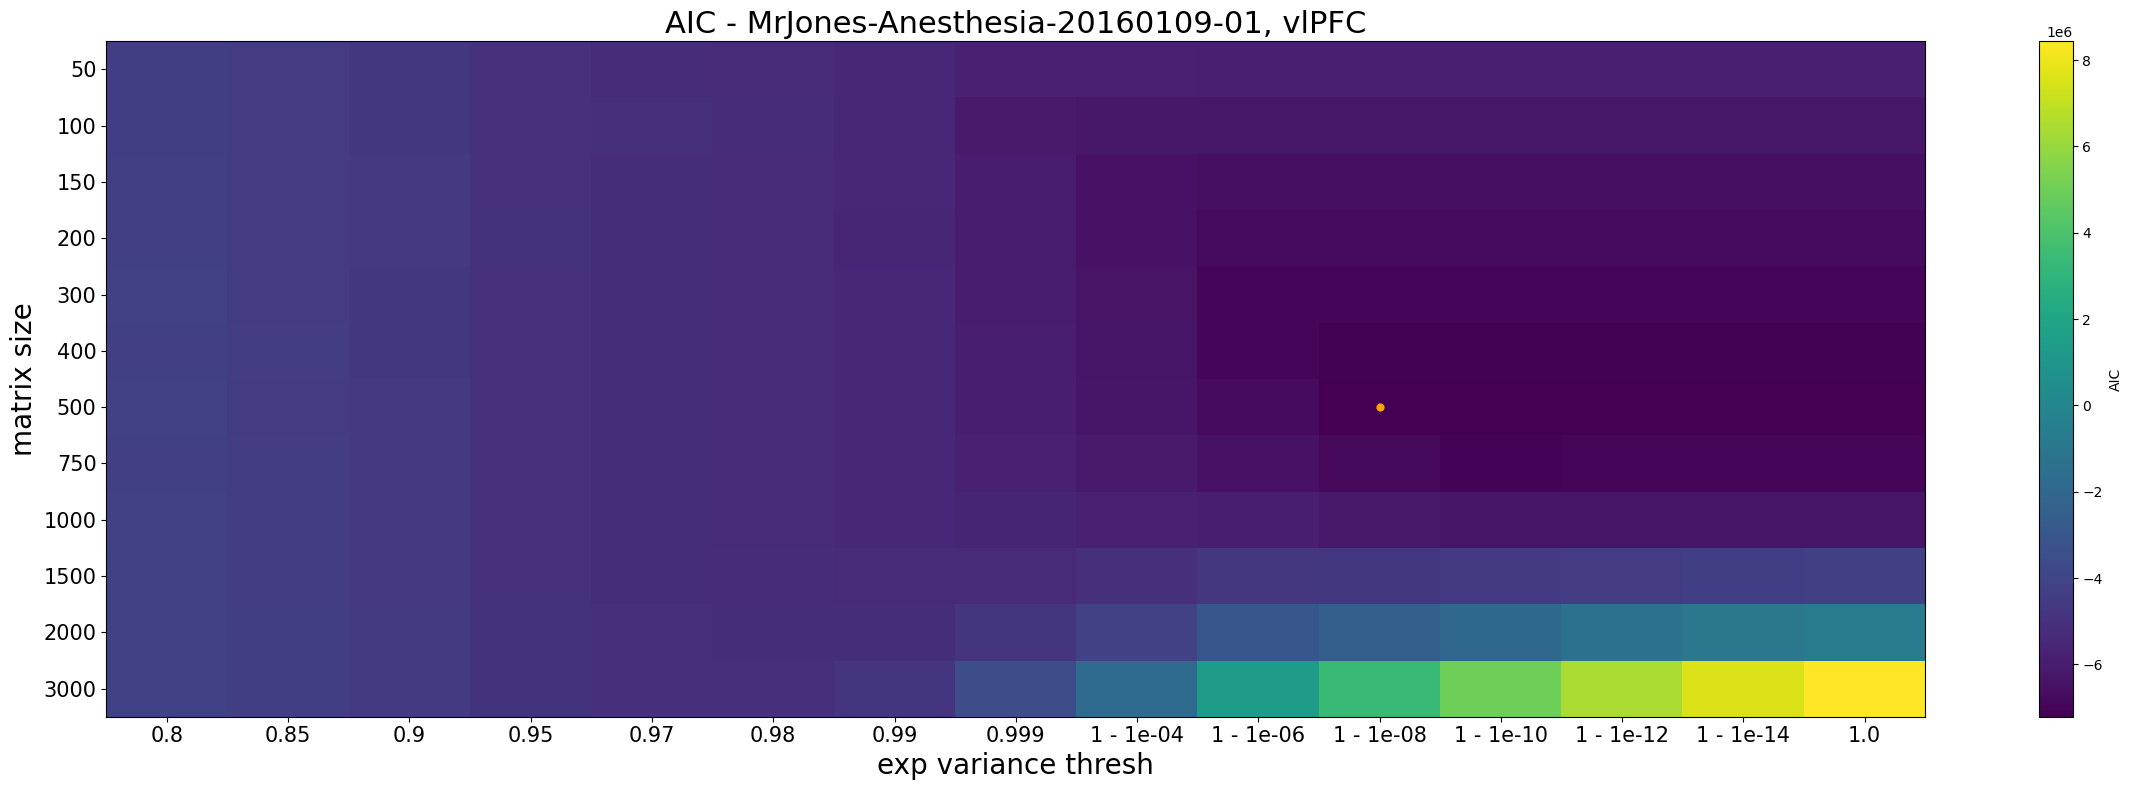

In [198]:
plt.figure(figsize=(24, 8))

norm = Normalize(vmin=AIC_mean.min(),vmax=AIC_mean.max())

plt.imshow(AIC_mean, norm=norm, aspect='auto')
plt.yticks(np.arange(len(matrix_size_vals)), [f"{matrix_size}" for matrix_size in matrix_size_vals])
plt.ylabel("matrix size", fontsize=20)
plt.xticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" if (exp_variance_thresh <= 0.999 or exp_variance_thresh == 1) else f"1 - {1 - exp_variance_thresh:2.0e}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.xlabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=15)
ax.set_title(f'AIC - {session}, {area}', fontsize=22)
ax.scatter(t_index, m_index, c=picked_color, s=24)
plt.colorbar(ax=ax, label='AIC')

plt.tight_layout()
plt.show()

In [152]:
time_vals = [float(key[2:])/60 for key in signals.keys()]

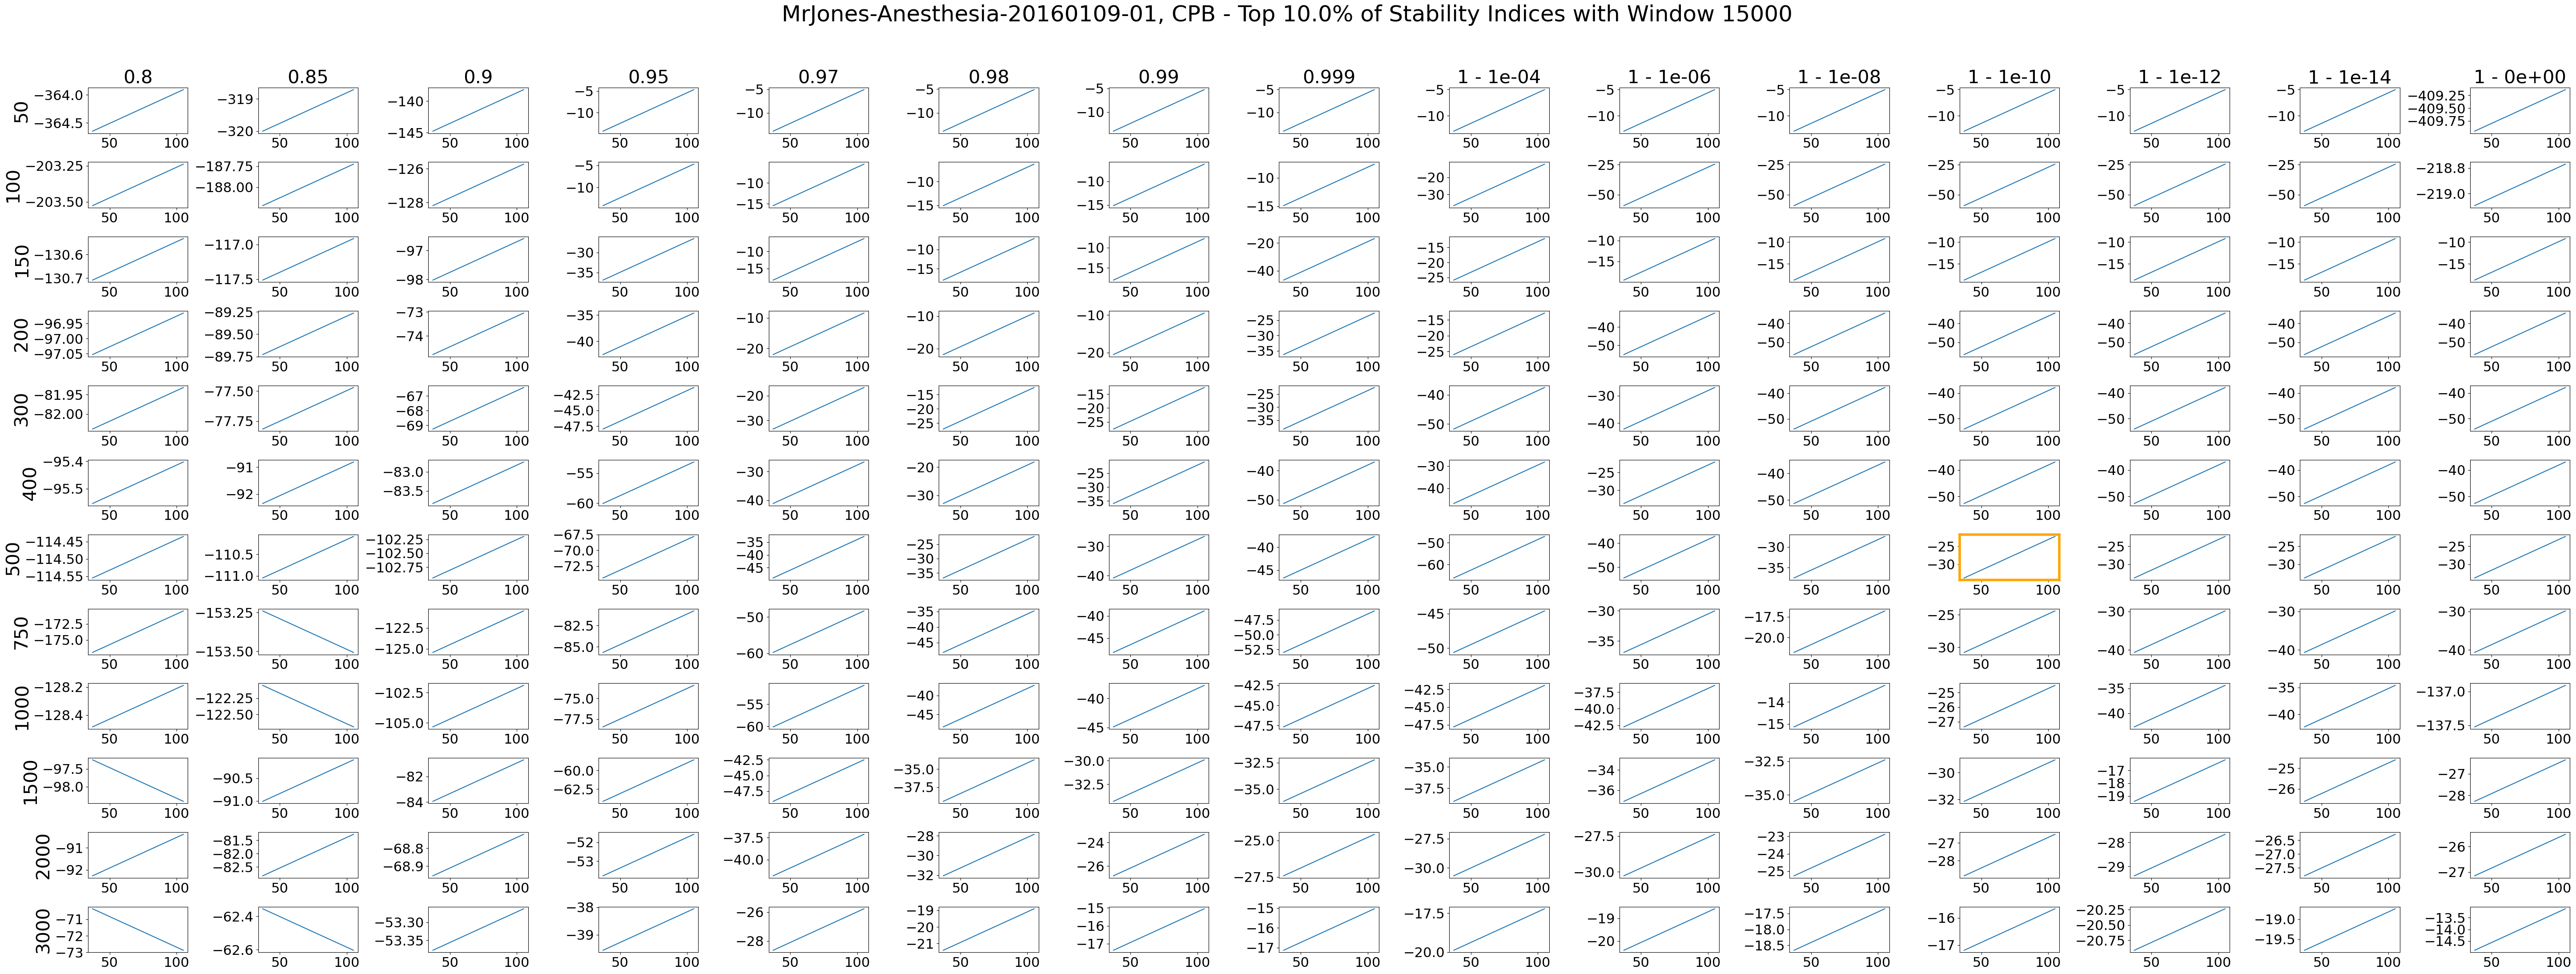

In [153]:
title_size = 30
label_size = 22
%matplotlib inline
fig, axs = plt.subplots(len(matrix_size_vals), len(exp_variance_thresh_vals), figsize=(58, 23))
for i, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
    for j, matrix_size in enumerate(matrix_size_vals):
        ax = axs[j][i]
        if mean_stab_curve:
            ax.plot(time_vals, stab_curve[(matrix_size, exp_variance_thresh)])
#             ax2 = ax.twinx()
#             ax2.plot(keys[key_inds], true_vals, linestyle='--', c='k')
            
#             ax2.tick_params(labelsize=label_size)
#             if j == m_index and i == t_index:
#                 for spine in ax2.spines.values():
#                     spine.set_color(picked_color)
#                     spine.set_linewidth(6)
        else:
            for ind, curve in enumerate(stab_curve[(matrix_size, exp_variance_thresh)]):
                ax.plot(curve)
                
        if j == 0:
            ax.set_title(f'{exp_variance_thresh}' if exp_variance_thresh <= 0.999 else f"1 - {1 - exp_variance_thresh:2.0e}", fontsize=title_size)
        if i == 0:
            ax.set_ylabel(f'{matrix_size}', fontsize=title_size)
        ax.tick_params(labelsize=label_size)
            
        if j == m_index and i == t_index:
            for spine in ax.spines.values():
                spine.set_color(picked_color)
                spine.set_linewidth(4)
            
#                 ax.spines['bottom'].set_color(picked_color)
#                 ax.spines['top'].set_color(picked_color) 
#                 ax.spines['right'].set_visible(False)
#                 ax.spines['left'].set_color(picked_color)

#                 ax2.spines['bottom'].set_color(picked_color)
#                 ax2.spines['top'].set_color(picked_color) 
#                 ax2.spines['right'].set_color(picked_color)
#                 ax2.spines['left'].set_visible(False)
            
        
plt.suptitle(f'{session}, {area} - Top {top_percent*100}% of Stability Indices with Window {window}', fontsize=36)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
r_vals = np

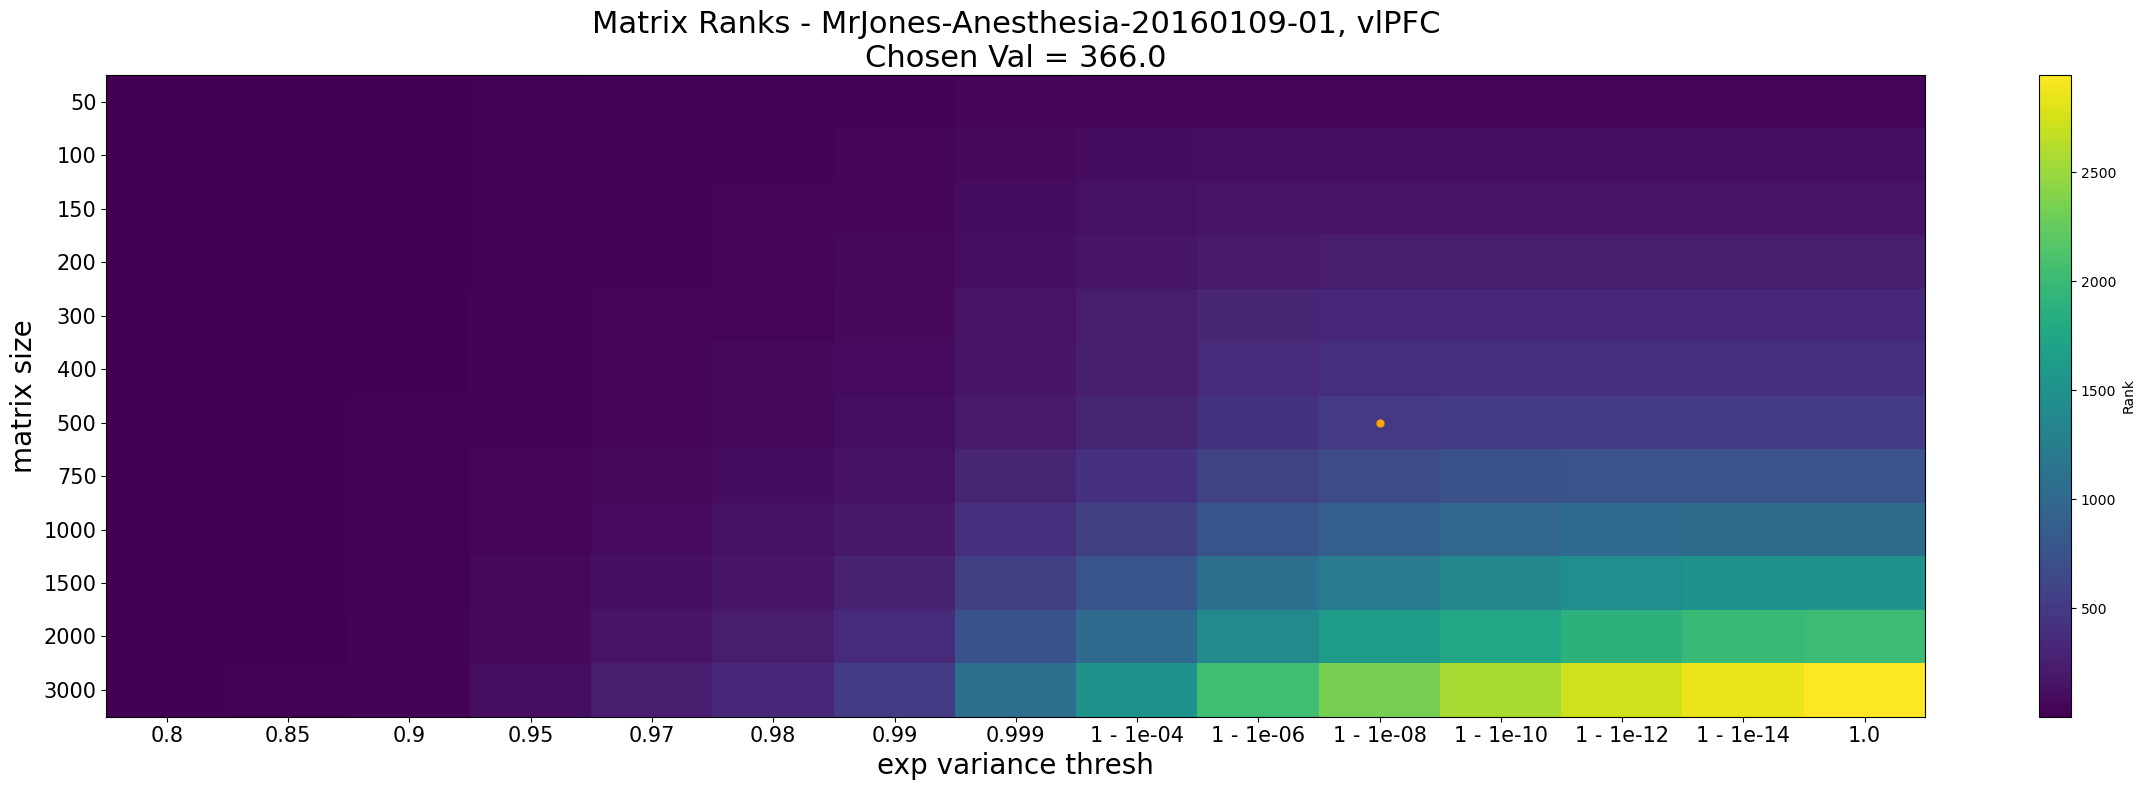

In [199]:
plt.figure(figsize=(24, 8))

norm = Normalize(vmin=r_vals.min(),vmax=r_vals.max())

plt.imshow(r_vals, norm=norm, aspect='auto')
plt.yticks(np.arange(len(matrix_size_vals)), [f"{matrix_size}" for matrix_size in matrix_size_vals])
plt.ylabel("matrix size", fontsize=20)
plt.xticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" if (exp_variance_thresh <= 0.999 or exp_variance_thresh == 1) else f"1 - {1 - exp_variance_thresh:2.0e}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.xlabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=15)
ax.set_title(f'Matrix Ranks - {session}, {area}\nChosen Val = {r_vals[t_index, m_index]}', fontsize=22)
ax.scatter(t_index, m_index, c=picked_color, s=24)
plt.colorbar(ax=ax, label='Rank')

plt.tight_layout()
plt.show()

In [200]:
np.min(r_vals)

3.0

In [201]:
np.max(r_vals)

2947.0